In [5]:

!pip install -U deeplake

In [6]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [7]:
# Loading the PlantVillage Dataset with Augmentation Subset
import hub
ds = hub.load('hub://activeloop/plantvillage-with-augmentation')

/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/plantvillage-with-augmentation



-

hub://activeloop/plantvillage-with-augmentation loaded successfully.



In [8]:
# Visualizing the PlantVillage Datase
ds.visualize()

HINT: Please forward the port - 58248 to your local machine, if you are running on the cloud.
 * Serving Flask app "dataset_visualizer" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [9]:
# exploring the Dataset
# Print the shapes of images and labels
print("Shape of images:", ds['images'].shape)
print("Shape of labels:", ds['labels'].shape)

# Display the first few unique labels (classes) in the dataset
unique_labels = np.unique(ds['labels'][:])
print("Unique labels:", unique_labels)

# Check if all the 39 classes are present
if len(unique_labels) == 39:
    print("All 39 classes are present!")
else:
    missing_classes = set(range(1, 40)) - set(unique_labels)
    print(f"Missing classes: {missing_classes}")


Shape of images: (58775, None, None, 3)
Shape of labels: (58775, 1)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Missing classes: {14, 39}


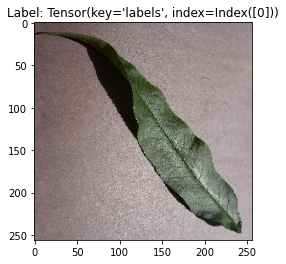

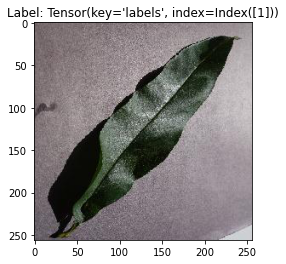

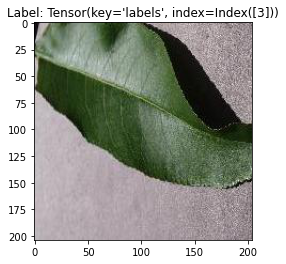

In [10]:
import matplotlib.pyplot as plt

# Plotting the first 4 images and their corresponding labels
for i in range(4):
    plt.imshow(ds['images'][i])
    plt.title(f"Label: {ds['labels'][i]}")
    plt.show()


In [11]:
# providing the class names as provided in the dataset as class labels
class_names = [
    "Peach_healthy",
    "Strawberry_leaf_scorch",
    "Grape_black_measles",
    "Tomato_septoria_leaf_spot",
    "Grape_healthy",
    "Tomato_healthy",
    "Peach_bacterial_spot",
    "Corn_gray_leaf_spot",
    "Soybean_healthy",
    "Corn_common_rust",
    "Blueberry_healthy",
    "Corn_healthy",
    "Apple_healthy",
    "Apple_cedar_apple_rust",
    "Background_without_leaves",
    "Tomato_target_spot",
    "Pepper_healthy",
    "Grape_black_rot",
    "Apple_scab",
    "Raspberry_healthy",
    "Tomato_early_blight",
    "Tomato_yellow_leaf_curl_virus",
    "Corn_northern_leaf_blight",
    "Potato_healthy",
    "Tomato_late_blight",
    "Cherry_powdery_mildew",
    "Grape_leaf_blight",
    "Tomato_leaf_mold",
    "Pepper_bacterial_spot",
    "Potato_late_blight",
    "Tomato_mosaic_virus",
    "Potato_early_blight",
    "Tomato_bacterial_spot",
    "Strawberry_healthy",
    "Cherry_healthy",
    "Squash_powdery_mildew",
    "Tomato_spider_mites_two-spotted_spider_mite",
    "Orange_haunglongbing",
    "Apple_black_rot"
]


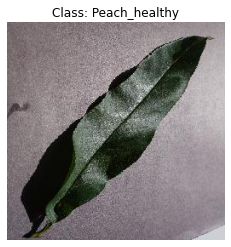

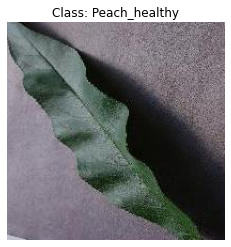

In [12]:
import matplotlib.pyplot as plt

# Using the class_names to map the labels to their names
for i in range(4):
    plt.imshow(ds['images'][i])
    
    # Convert tensor to an integer
    label_index = int(ds['labels'][i].numpy())
    
    plt.title(f"Class: {class_names[label_index]}")
    plt.axis('off')
    plt.show()


In [13]:
#1. Data Exploration:
#a. Check the distribution of different classes.
import numpy as np

labels_array = ds['labels'][:]  # Get all labels
unique, counts = np.unique(labels_array, return_counts=True)

# Print class distribution
for u, c in zip(unique, counts):
    print(f"{class_names[u]}: {c}")


Peach_healthy: 1000
Strawberry_leaf_scorch: 1108
Grape_black_measles: 1383
Tomato_septoria_leaf_spot: 1771
Grape_healthy: 1000
Tomato_healthy: 1590
Peach_bacterial_spot: 2297
Corn_gray_leaf_spot: 870
Soybean_healthy: 5090
Corn_common_rust: 1192
Blueberry_healthy: 1502
Corn_healthy: 21
Apple_healthy: 1645
Apple_cedar_apple_rust: 1000
Tomato_target_spot: 1404
Pepper_healthy: 1476
Grape_black_rot: 1180
Apple_scab: 1000
Raspberry_healthy: 1000
Tomato_early_blight: 1000
Tomato_yellow_leaf_curl_virus: 5357
Corn_northern_leaf_blight: 882
Potato_healthy: 1000
Tomato_late_blight: 1756
Cherry_powdery_mildew: 1052
Grape_leaf_blight: 1076
Tomato_leaf_mold: 1000
Pepper_bacterial_spot: 1000
Potato_late_blight: 1000
Tomato_mosaic_virus: 1000
Potato_early_blight: 1000
Tomato_bacterial_spot: 2127
Strawberry_healthy: 1000
Cherry_healthy: 1000
Squash_powdery_mildew: 1813
Tomato_spider_mites_two-spotted_spider_mite: 1676
Orange_haunglongbing: 5507
Apple_black_rot: 1000


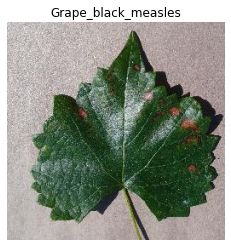

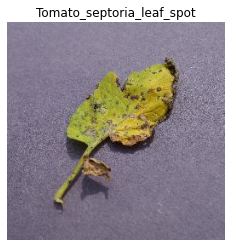

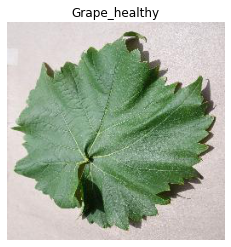

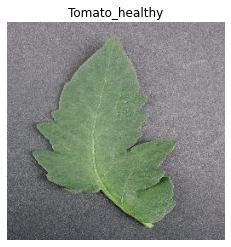

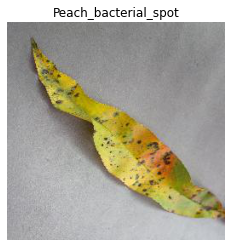

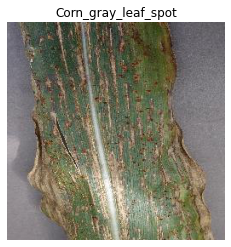

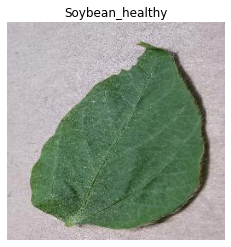

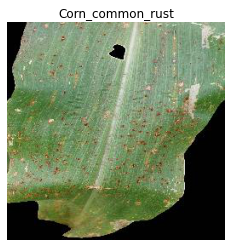

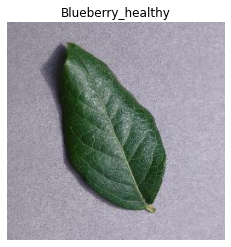

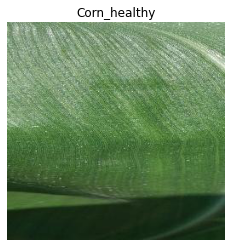

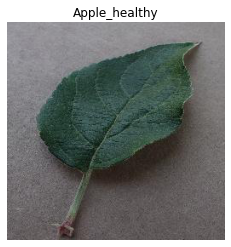

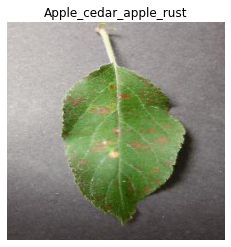

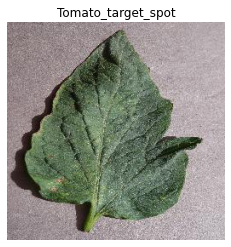

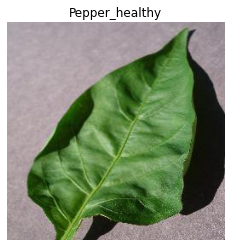

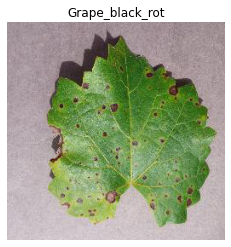

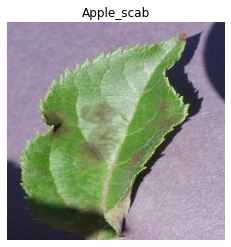

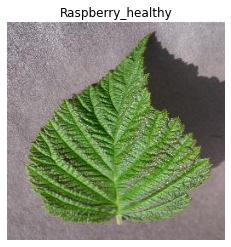

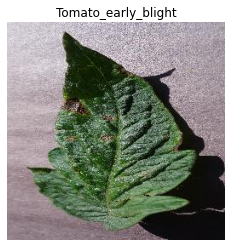

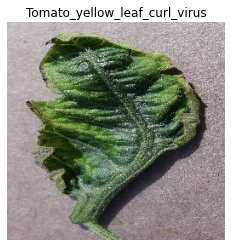

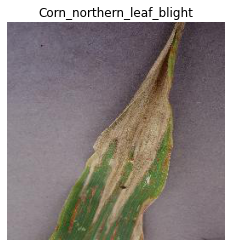

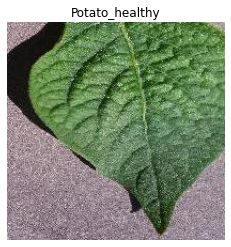

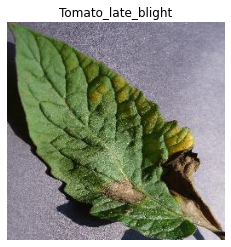

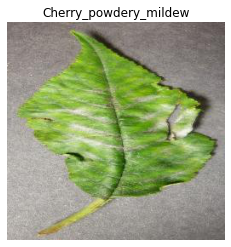

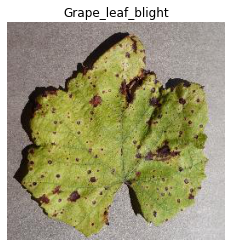

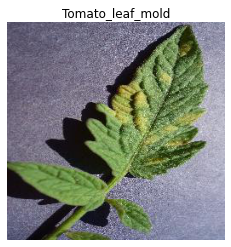

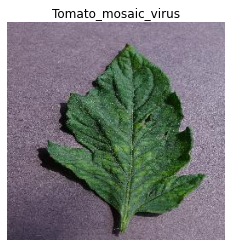

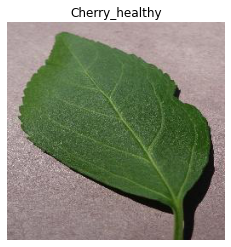

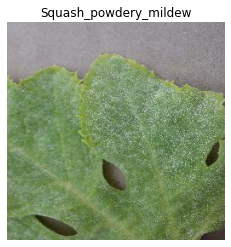

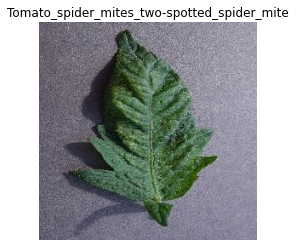

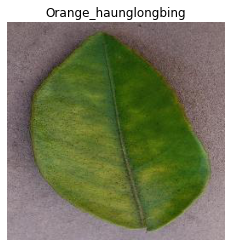

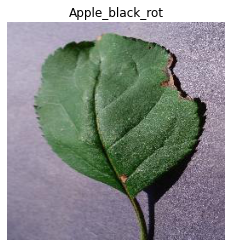

In [14]:
# This will display one image from each class
for label in unique:
    idx = int(np.where(labels_array == label)[0][0])  # Convert numpy int64 to int
    plt.imshow(ds['images'][idx])
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()


In [15]:
# the original dataset is in read only format. So making a copy of the images and labels, so that we can work on it.
images_copy = ds['images'][:]
labels_copy = ds['labels'][:]

In [16]:
# Import the TensorFlow library
import tensorflow as tf

# 3. Batch Processing
# Define the batch size for processing the images in chunks.
# This is useful when dealing with a large dataset to avoid memory issues.
batch_size = 1000

# Calculate the total number of batches by dividing the total number of images by the batch size.
num_batches = len(images_copy) // batch_size

# Create an empty list to store the batches of resized images.
resized_images_batches = []

# Define the target size to which all the images will be resized.
target_size = (64, 64)

# Loop over each batch of images.
# The loop will run for "num_batches + 1" times to also account for the final batch which might be smaller than the batch size.
for batch_num in range(num_batches + 1):
    
    # Calculate the starting index of the current batch in the image list.
    start_idx = batch_num * batch_size
    
    # Calculate the ending index of the current batch in the image list.
    end_idx = start_idx + batch_size
    
    # Extract the current batch of images from the list.
    current_batch = images_copy[start_idx:end_idx]
    
    # Resize all the images in the current batch to the target size.
    # The result is a list of resized images.
    resized_batch = [tf.image.resize(img, target_size).numpy() for img in current_batch]
    
    # Append the resized batch to the list of all resized batches.
    resized_images_batches.append(np.array(resized_batch))


In [17]:
# Convert the labels_copy list to a numpy array for easier slicing and manipulation.
labels_copy_np = np.array(labels_copy[:])

from sklearn.model_selection import train_test_split

# Create empty lists to store batches of training, validation, and test data.
train_batches = []
val_batches = []
test_batches = []

# Loop through each batch of resized images to split them into training, validation, and test sets.
for i, batch in enumerate(resized_images_batches):
    # Calculate the start and end indices for the current batch of labels.
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    # Slice the labels array to get the current batch of labels.
    current_labels_batch = labels_copy_np[start_idx:end_idx]

    # Split the current batch of images and labels into training and a temporary set.
    # 70% of data goes to training and 30% goes to the temporary set.
    X_train_batch, X_temp_batch, y_train_batch, y_temp_batch = train_test_split(
        batch, current_labels_batch, test_size=0.3, random_state=42)
    
    # Further split the temporary set (which is 30% of the original batch)
    # into validation and test sets. Each of these will be 15% of the original batch.
    X_val_batch, X_test_batch, y_val_batch, y_test_batch = train_test_split(
        X_temp_batch, y_temp_batch, test_size=0.5, random_state=42)
    
    # Append the split data to the respective batches list.
    train_batches.append((X_train_batch, y_train_batch))
    val_batches.append((X_val_batch, y_val_batch))
    test_batches.append((X_test_batch, y_test_batch))

# At this point, the resized_images_batches have been split and organized into
# separate training, validation, and test batches.


In [18]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)    # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)    # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)    # Random contrast
    return image

augmented_train_batches = []

# Apply augmentation and normalization only on training batches
for (X_batch, y_batch) in train_batches:
    augmented_X_batch = np.array([augment_image(img).numpy() for img in X_batch])
    
    # Normalize the augmented images
    augmented_X_batch = augmented_X_batch / 255.0

    augmented_train_batches.append((augmented_X_batch, y_batch))

# Normalize validation batches
for index, (X_batch, y_batch) in enumerate(val_batches):
    X_batch = X_batch / 255.0
    val_batches[index] = (X_batch, y_batch)

# Normalize test batches
for index, (X_batch, y_batch) in enumerate(test_batches):
    X_batch = X_batch / 255.0
    test_batches[index] = (X_batch, y_batch)


In [19]:
!pip install transformers
import tensorflow as tf


In [20]:
# Define a dropout layer that will drop 50% of the neurons during training.
# This helps prevent overfitting by adding regularization to the model.
dropout_layer = tf.keras.layers.Dropout(0.5) # 50% dropout

# Load the MobileNetV2 model 
# This model is efficient and works well for mobile and edge devices.
base_model = tf.keras.applications.MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Make the MobileNetV2 layers trainable.
# This allows fine-tuning where our dataset's specific features can be better captured by updating the model's weights.
base_model.trainable = True  # Allow fine-tuning

# Define a global average pooling layer.
# This layer converts the feature maps from the base model into a single vector per image.
# It averages over the spatial dimensions, which reduces the number of parameters and computation.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Define the prediction layer.
# This is the final layer which will output probability scores for each of the 39 classes in our dataset.
# Softmax activation function ensures the output values are between 0 and 1 and sum to 1.
prediction_layer = tf.keras.layers.Dense(39, activation='softmax') 

# Assemble the final model using the Sequential API.
# The model consists of the base model (MobileNetV2), followed by the dropout layer for regularization,
# the global average pooling layer for dimensionality reduction, and finally the prediction layer.
model = tf.keras.Sequential([
    base_model,
    dropout_layer,
    global_average_layer,
    prediction_layer
])


In [21]:
print(X_train_batch.shape)
print(y_train_batch.shape)
print(np.unique(y_train_batch))
all_train_labels = np.concatenate([y for _, y in train_batches])
all_val_labels = np.concatenate([y for _, y in val_batches])
all_test_labels = np.concatenate([y for _, y in test_batches])

print(np.unique(all_train_labels))
print(np.unique(all_val_labels))
print(np.unique(all_test_labels))

(542, 64, 64, 3)
(542, 1)
[38]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [22]:
#. Model Compilation
#Before training the model, it needs to be compiled with an optimizer, a loss function, and some metrics to monitor during training:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])



Epoch 1/10
1286/1286 [==============================] - 533s 384ms/step - loss: 0.7230 - accuracy: 0.7944 - val_loss: 10.8213 - val_accuracy: 0.3152
Epoch 2/10
1286/1286 [==============================] - 478s 372ms/step - loss: 0.2995 - accuracy: 0.9075 - val_loss: 2.6416 - val_accuracy: 0.7001
Epoch 3/10
1286/1286 [==============================] - 474s 368ms/step - loss: 0.2403 - accuracy: 0.9250 - val_loss: 1.2151 - val_accuracy: 0.8426
Epoch 4/10
1286/1286 [==============================] - 476s 370ms/step - loss: 0.2036 - accuracy: 0.9370 - val_loss: 5.7407 - val_accuracy: 0.5116
Epoch 5/10
1286/1286 [==============================] - 490s 381ms/step - loss: 0.1785 - accuracy: 0.9430 - val_loss: 1.0568 - val_accuracy: 0.8596
Epoch 6/10
1286/1286 [==============================] - 472s 367ms/step - loss: 0.1488 - accuracy: 0.9542 - val_loss: 1.4915 - val_accuracy: 0.8034
Epoch 7/10
1286/1286 [==============================] - 471s 366ms/step - loss: 0.1297 - accuracy: 0.9584 - val

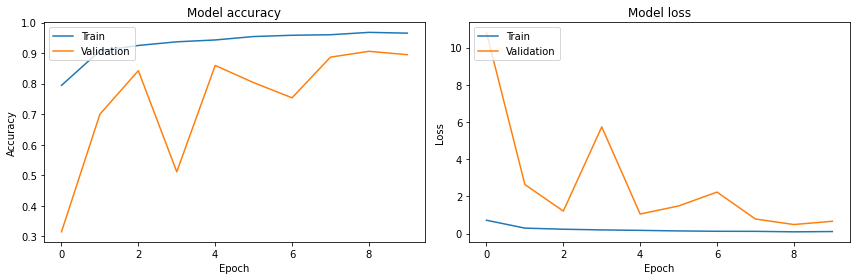

In [23]:
# 1. Prepare Data for Training
X_train_all = np.concatenate([X for X, _ in augmented_train_batches])
y_train_all = np.concatenate([y for _, y in augmented_train_batches])
X_val_all = np.concatenate([X for X, _ in val_batches])
y_val_all = np.concatenate([y for _, y in val_batches])

# 2. Train the Model
history = model.fit(X_train_all, y_train_all, 
                    validation_data=(X_val_all, y_val_all),
                    epochs=10, batch_size=32)  # You can adjust epochs and batch_size as needed

# 3. Evaluate the Model
X_test_all = np.concatenate([X for X, _ in test_batches])
y_test_all = np.concatenate([y for _, y in test_batches])

loss, accuracy = model.evaluate(X_test_all, y_test_all)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# 4. Visualize Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [24]:
model.save('my_model.keras')
#saving the model
